<center>

*******************************************************************************************
<font size="4">
Wavelet Coherence Transform &nbsp; &nbsp; <br>
</font>

##### 16 September 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* The Wavelet Coherence Transform (WCT) measures the time-frequency relationship between two periodic signals at different time-scales.
>
* Dependency:
    * [PyCWT](https://github.com/regeirk/pycwt)
>
* Tested with:
    * Python 3.11
    * Windows 11
>
* References:
    * Torrence, C., & Compo, G. P. (1998). A practical guide to wavelet analysis. *Bulletin of the American Meteorological society, 79*(1), 61-78.
    * Grinsted, A., Moore, J. C., & Jevrejeva, S. (2004). *Application of the cross wavelet transform and wavelet coherence to geophysical time series. Nonlinear processes in geophysics, 11*(5/6), 561-566.
    * Krieger, S., & Freij, N. (2024). *PyCWT: Wavelet spectral analysis in Python*. https://github.com/regeirk/pycwt
    * https://pycwt.readthedocs.io

>
* Instructions:
    * Ensure that the dependecies are installed.
    * Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys
import numpy as np

sys.path.append(r"..\src")
import syncoord as sc

***
### Generate synthetic data

index; key; Name; duration (s):
  0; 0; Test Data; 0:16.0


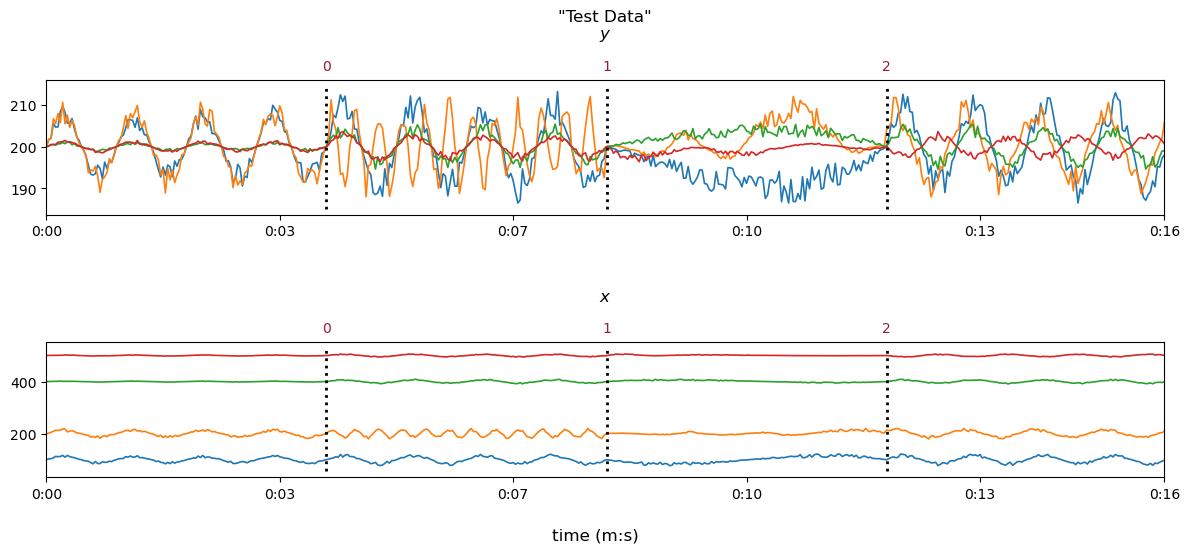

In [2]:
shuffseed = None  # <--- None = don't shuffle sections, int = shuffle sections

testdata_vars = sc.utils.init_testdatavars(seed=1)
if shuffseed is not None:
    rangen = np.random.default_rng(seed=shuffseed)
    rangen.shuffle(testdata_vars['point_vars'])
test_data_1 = sc.ptdata.load( testdata_vars, print_info=True )
test_data_1.visualise( vscale=1.2, dlattr='1.2' )

***
### Reduce to 1 Dimension per point

Methods:
* Norms: the sum of the L1 and L2 norms preserve the shape of the oscillation and is not affected by noise.
* Speed: rectifies the oscillation and is affected by noise, leading to artifacts when applying the Fourier Transform.

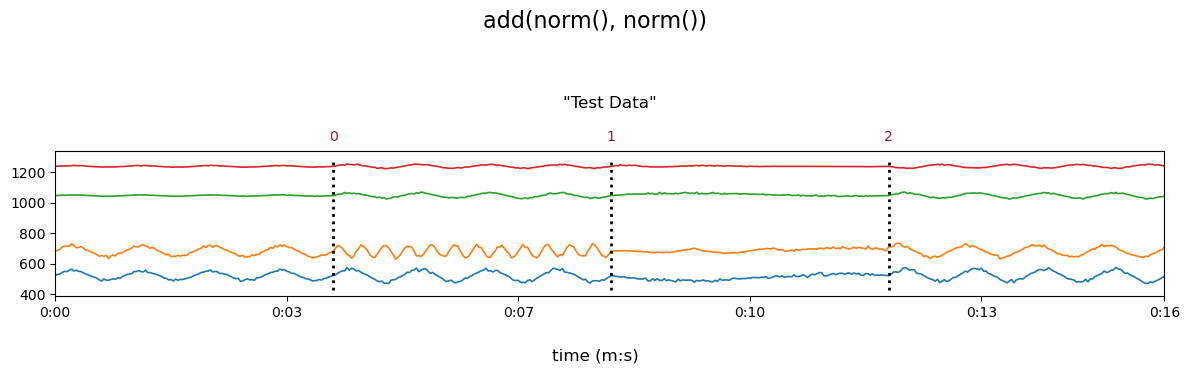

In [3]:
red1D_method = 'norms' # <--- 'norms' or 'speed'

if red1D_method == 'speed':
    test_data_2 = sc.ptdata.speed( test_data_1)
elif red1D_method == 'norms':
    n1 = sc.ptdata.norm( test_data_1, order=1, axis=-2 )
    n2 = sc.ptdata.norm( test_data_1, order=2, axis=-2 )
    test_data_2 = sc.ptdata.apply2( n1, n2, np.add )
else: raise Exception('invalid value for red1D_method')
test_data_2.visualise( vscale=1.4, dlattr='1.2' )

***
### Pairwise Wavelet Coherence Transform

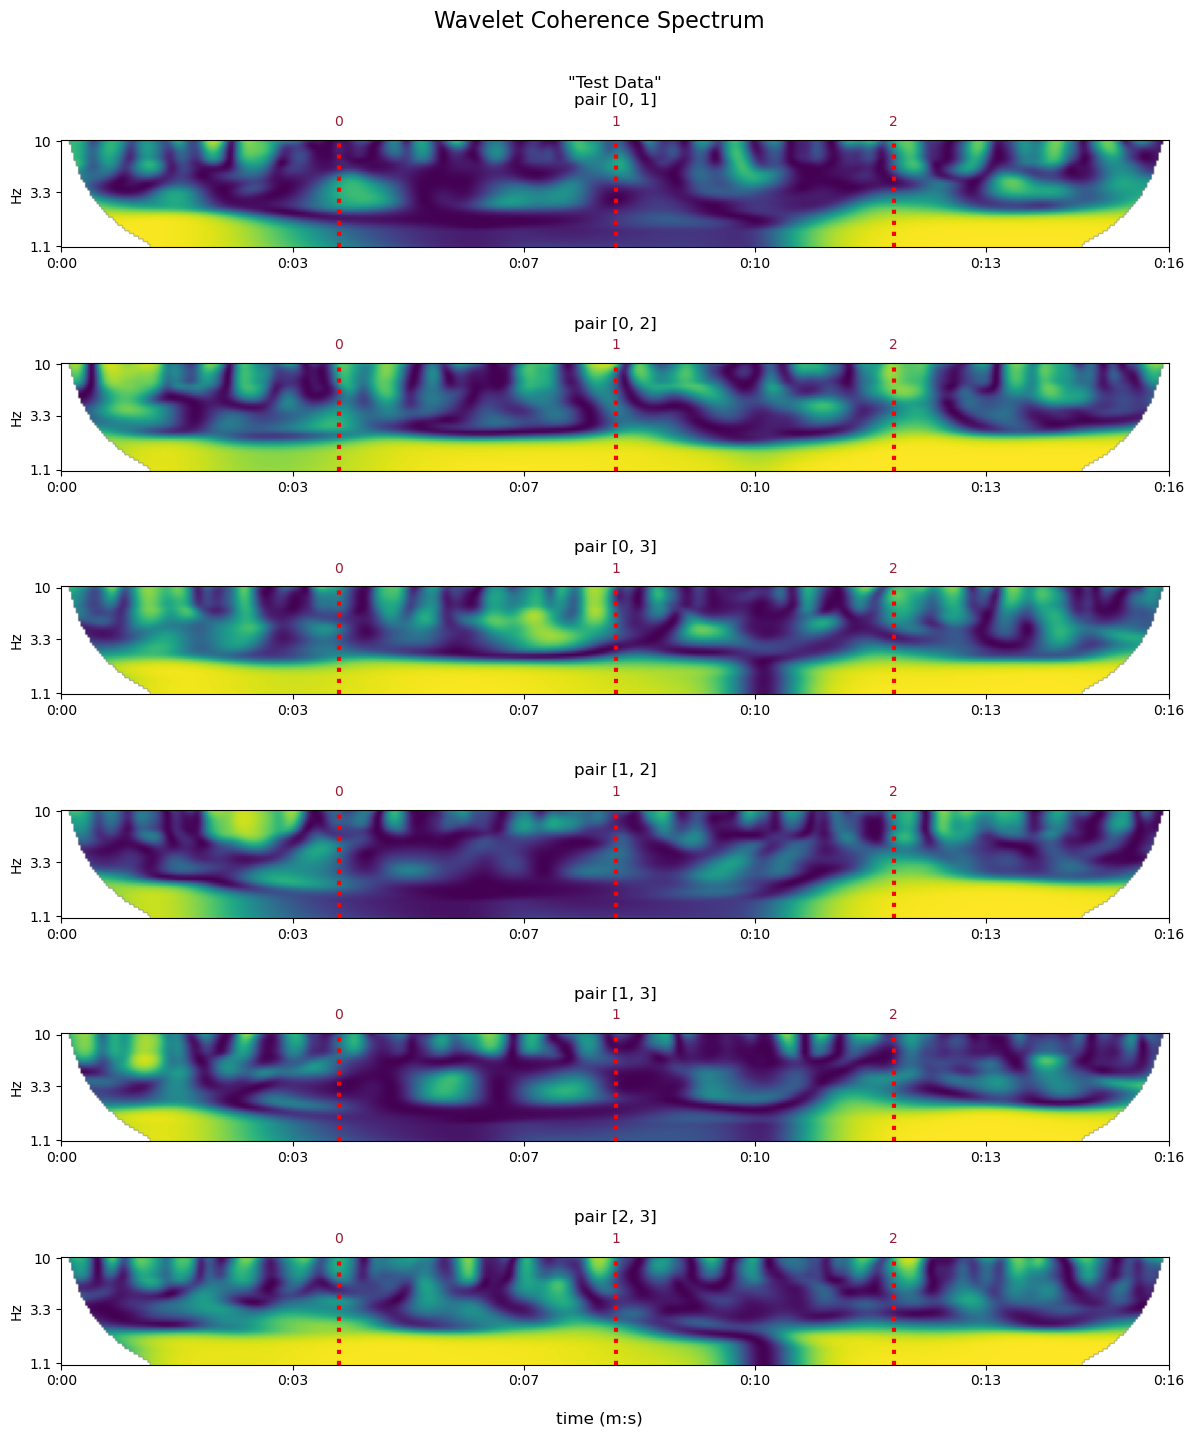

In [4]:
minmaxf = [1,10]  # <--- [minimum, maximum] frequency (Hz), can be the same
# minmaxf = [1,1]   # <--- [minimum, maximum] frequency (Hz), can be the same

wctdata = sc.ptdata.wct( test_data_2, minmaxf, pairs_axis=0, fixed_axes=-1, postprocess='coinan' )
wctp_vscale = 1
many_tscales = True
if len(set(minmaxf)) == 1:
    wctp_vscale = 0.7
    many_tscales = False
wctdata.visualise( vscale=wctp_vscale, dlattr='1.2' )

>
#### Average Wavelet Coherence Transform for group

C:\Users\juigmend\local_documents\SynCoord\src\syncoord\ptdata.py:1188: RuntimeWarning: Mean of empty slice
  dd_out[k] = np.nanmean(dd_in[k],axis=axis)


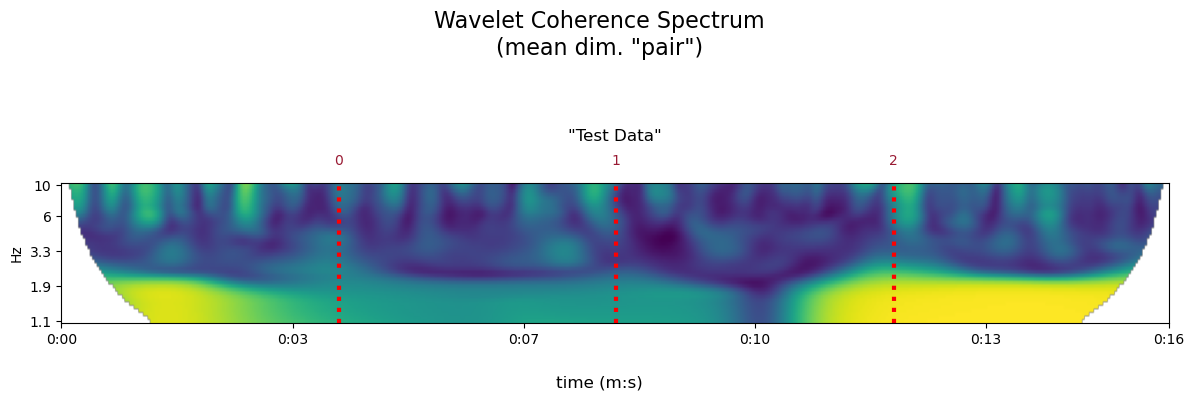

In [5]:
wctdata_aggr_pairs = sc.ptdata.aggrax( wctdata, axis=0, function='mean' )

max_n_nan = 0 # maximum number of frames affected by cone of influence
aggp_vscale = 1.4
if many_tscales: rows = wctdata_aggr_pairs.data[0]
else:
    aggp_vscale = 1.1
    rows = [wctdata_aggr_pairs.data[0]]
for row in rows:
    n_nan_row = sum(np.isnan(row))
    if n_nan_row > max_n_nan: max_n_nan = n_nan_row

wctdata_aggr_pairs.visualise( vscale=aggp_vscale, dlattr='1.2' )

>
#### Average Wavelet Coherence Transform for group

C:\Users\juigmend\local_documents\SynCoord\src\syncoord\ptdata.py:1188: RuntimeWarning: Mean of empty slice
  dd_out[k] = np.nanmean(dd_in[k],axis=axis)


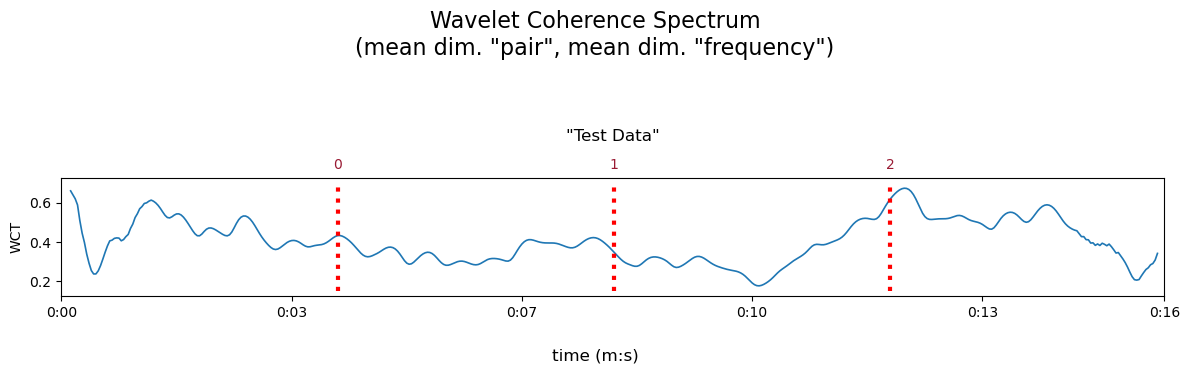

In [6]:
if many_tscales:
    wctdata_aggr_top = sc.ptdata.aggrax( wctdata_aggr_pairs, axis=0, function='mean' )
    wctdata_aggr_top.visualise( vscale=1.3, vistype='line', dlattr='1.2' )
else:
    wctdata_aggr_top = wctdata_aggr_pairs

>
#### Sections' statistics

means = [0.451, 0.351, 0.332, 0.479]


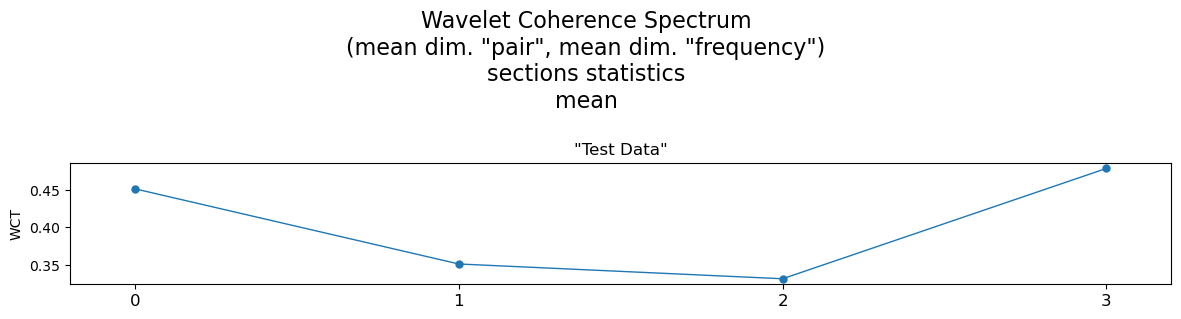

In [7]:
# Set margins to be as the maximum number of frames affected by the cone of influence:
# margin_s = max_n_nan.item()/2/wctdata_aggr_top.topinfo.fps[0].item()
# n_sections = len(wctdata_aggr_top.topinfo.trimmed_sections_frames[0])+1
# sec_margins = [[margin_s,margin_s] for _ in range(n_sections)] # <--- sections' margins (seconds)

sec_margins = None # <--- sections' margins (seconds)

wctdata_aggr_top_stats = sc.ptdata.secstats( wctdata_aggr_top, margins=sec_margins,
                                             omitnan=True, last=True )

wctdata_aggr_top_stats.visualise( statistics='mean' )
print('means =','['+', '.join([str(v) for v in np.round(wctdata_aggr_top_stats.data[0][0],3)])+']')

import matplotlib.pyplot as plt
plt.xlim((-0.2,3.2))
plt.xticks((0,1,2,3),('0','1','2','3'),fontsize=12);